## 1. Download Precipitation and Isotope NEON data

In [ ]:
# Load rpy2 so R scripts can run within jupyter notebook
%load_ext rpy2.ipython

In [ ]:
# This rpy2 'Rmagic' command allows to run the entire cell block as R code
%%R 

# Install R packages
install.packages("neonUtilities")
install.packages('openxlsx')


In [ ]:
%%R

# Load required libraries
library(neonUtilities)
library(openxlsx)

# Download and export ONAQ isotope data --> change this to all sites??
ONAQIsoData <- loadByProduct(dpID="DP1.00038.001", site=c("ONAQ"))
list2env(ONAQIsoData, .GlobalEnv)
write.xlsx(wdi_isoPerSample, "~/Desktop/NEON/Temporal_Downscaling_NEON_Pisotopes/ONAQIsoData.xlsx", row.names=F)

# downloading and exporting ONAQ precipitation data
ONAQPrecipData <- loadByProduct(dpID="DP1.00006.001", site=c("ONAQ"))
list2env(ONAQPrecipData, .GlobalEnv)
write.xlsx(PRIPRE_30min, "~/Desktop/NEON/Temporal_Downscaling_NEON_Pisotopes/ONAQPrecipData.xlsx", row.names=F)

## 2. Generate a downscaled daily data product at each NEON site

In [1]:
## Python Import Statements
import pandas as pd
import numpy as np
import os
import scipy as sp
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt

import changeTimes
import getRunningMean
import conditional_copula_ts

In [2]:
ROOTDIR = os.getcwd()

# 30min Precipitation Data
df_P30 = pd.read_excel(ROOTDIR+'/ONAQPrecipData.xlsx',index=False) # figure out how to organize so we can iterate through all sites
df_P30 = changeTimes.change_Pdata(df_P30)

# Biweekly Stable Water Isotope Data
df_iso = pd.read_excel(ROOTDIR+'/ONAQIsoData.xlsx',index=False)
df_iso = changeTimes.change_ISOdata(df_iso)

In [3]:
# Create Biweekly Precipitation Amount Timeseries to Correspond to Recorded Isotope Values
df_iso['setDate'] = pd.to_datetime(df_iso['setDate'])  
df_iso['collectDate'] = pd.to_datetime(df_iso['collectDate']) 

P14 = []
for i in np.arange(len(df_iso['setDate'])):
    mask = ((df_P30['DateTime'] > df_iso['setDate'].iloc[i]) 
            & (df_P30['DateTime'] <= df_iso['collectDate'].iloc[i]))
    
    df_sub = df_P30.loc[mask]
    P14.append(np.sum(df_sub['priPrecipBulk'].values))

df_iso['Total P'] = P14
del P14, i, mask

print(df_iso)

                                     uid            namedLocation  \
0   ed75636e-d435-4543-8a67-fef1161343a1  ONAQ.TOS.wet.deposition   
1   c3af194e-c2a4-4ddd-b5d5-38624f9a9e2b  ONAQ.TOS.wet.deposition   
2   09724a6a-95b6-4e25-ae3c-8530dec6c83c  ONAQ.TOS.wet.deposition   
3   f3cd9bc2-7600-42ce-8bde-66c470a92a07  ONAQ.TOS.wet.deposition   
4   6c17072f-7f62-467f-bf3d-2396b89ebf4b  ONAQ.TOS.wet.deposition   
5   1b574b8d-d461-4683-876d-a247c99a173e  ONAQ.TOS.wet.deposition   
6   940e3aaf-39c7-4b5e-91b6-15c4dc8364ab  ONAQ.TOS.wet.deposition   
7   68cf4f0a-902f-4bd4-937f-fea61b74c81f  ONAQ.TOS.wet.deposition   
8   58d7e4d0-d15f-4d4e-a685-b0ea11a68e13  ONAQ.TOS.wet.deposition   
9   c5bbff97-05fa-4267-8ed4-4b84b2e3306e  ONAQ.TOS.wet.deposition   
10  4698802c-5c58-4ff5-9ce1-492466f18099  ONAQ.TOS.wet.deposition   
11  2eb30d47-bc0d-4f1d-8f2c-a0a9ad13efe1  ONAQ.TOS.wet.deposition   
12  b92d414e-afb9-4183-ab36-610b77537566  ONAQ.TOS.wet.deposition   
13  0e3bb5b7-80a4-40dc-9d39-7c5f79

In [5]:
# Sum Daily Precipitation Amounts
df_P30b = df_P30.set_index('DateTime')
precip_daily = df_P30b['priPrecipBulk'].resample('D').sum() # sum total daily P
frac_year = df_P30b['FracYear'].resample('D').mean() # average daily FracYear

daily_P = pd.DataFrame({'Total P':precip_daily,'FracYear':frac_year})
daily_P['Total P'].replace(0, np.nan, inplace=True)
print(daily_P)

            Total P  FracYear
DateTime                     
2017-07-08     1.02  0.517454
2017-07-09     0.88  0.520192
2017-07-10     0.61  0.522930
2017-07-11     0.60  0.525667
2017-07-12     0.67  0.528405
...             ...       ...
2020-06-27     0.12  0.490075
2020-06-28     0.58  0.492813
2020-06-29     2.56  0.495551
2020-06-30     0.33  0.498289
2020-07-01      NaN  0.501027

[1090 rows x 2 columns]


Step 1 - Remove seasonal time series component (Section 2.b.1)

In [11]:
# Define Sine Wave Functions
def sine_wave(t, amplitude, phase, offset):
    return amplitude * np.sin(2*np.pi*t - phase) + offset  # assume phase is decimal year/year

def sin_curves(name,agglevel,frac_yr,P,H,O):   
    param_bounds=([0,-np.pi,-np.inf],[np.inf,np.pi,np.inf])               
    
    # d2H - find parameters for sine function based on frac year 
    params1, params_covariance = optimize.curve_fit(sine_wave, frac_yr, H, p0 = [np.std(H)*(2*np.sqrt(2)),np.pi/2,np.mean(H)], bounds = param_bounds)
    # d18O - find parameters for sine function based on frac year 
    params2, params_covariance = optimize.curve_fit(sine_wave, frac_yr, O, p0 = [np.std(O)*(2*np.sqrt(2)),np.pi/2,np.mean(O)], bounds = param_bounds)
      
    return params1, params2

df_iso = df_iso.sort_values('DateTime')
df_iso = df_iso.dropna(subset=['Total P'])
tsX = df_iso['FracYear'].values 
tsP = df_iso['Total P'].values
tsO = df_iso['d18OWater'].values
tsH = df_iso['d2HWater'].values   

dayslist = []
for dt in np.arange(len(df_iso['DateTime'])):
    dayslist.append((df_iso['DateTime'].iloc[dt] - df_iso['DateTime'].iloc[0]).days)
dayslist = np.array(dayslist)

# this is precipitation frequency (see Eq. 4)
p_events = df_iso[df_iso['Total P'].notna()]
print(p_events)
lamda = len(p_events)/((daily_P.index.max() - daily_P.index.min()).days) 
print(lamda)
sitename = str((df_iso['sampleID'].iloc[0])[4:8])

params1, params2 = sin_curves(sitename,14,tsX,tsP,tsH,tsO) # 14 = biweekly sample, sample frequency
tsY_sine_wave = sine_wave(tsX, params1[0],params1[1],params1[2]) # solve for amplitude, phase, offset
adj_2H = np.array((tsH - tsY_sine_wave))    # remove seasonality from time series                       

tsY_sine_wave = sine_wave(tsX, params2[0],params2[1],params2[2])     
adj_18O = np.array((tsO - tsY_sine_wave))  

                                     uid            namedLocation  \
1   c3af194e-c2a4-4ddd-b5d5-38624f9a9e2b  ONAQ.TOS.wet.deposition   
2   09724a6a-95b6-4e25-ae3c-8530dec6c83c  ONAQ.TOS.wet.deposition   
3   f3cd9bc2-7600-42ce-8bde-66c470a92a07  ONAQ.TOS.wet.deposition   
4   6c17072f-7f62-467f-bf3d-2396b89ebf4b  ONAQ.TOS.wet.deposition   
7   68cf4f0a-902f-4bd4-937f-fea61b74c81f  ONAQ.TOS.wet.deposition   
8   58d7e4d0-d15f-4d4e-a685-b0ea11a68e13  ONAQ.TOS.wet.deposition   
9   c5bbff97-05fa-4267-8ed4-4b84b2e3306e  ONAQ.TOS.wet.deposition   
11  2eb30d47-bc0d-4f1d-8f2c-a0a9ad13efe1  ONAQ.TOS.wet.deposition   
12  b92d414e-afb9-4183-ab36-610b77537566  ONAQ.TOS.wet.deposition   
14  ae83d923-a87c-4d7e-b6c4-6a8a883cbdd3  ONAQ.TOS.wet.deposition   
15  f7fb1abf-169e-4716-9564-f0d3028ee65d  ONAQ.TOS.wet.deposition   
16  d456b15a-404f-49a4-ae1b-60d7e9f44e33  ONAQ.TOS.wet.deposition   
18  46a2d927-feb0-4cd7-a61e-fb9f220cc47f  ONAQ.TOS.wet.deposition   
21  3cdc9926-2fdf-4fe5-9325-18c2ba

In [12]:
# Get biweekly site stats
biweekly_stats = np.array([[np.mean(tsP), np.mean(adj_2H), np.mean(adj_18O)],
                 [np.std(tsP), np.std(adj_2H), np.std(adj_18O)],
                 [sp.stats.pearsonr(tsP,adj_2H)[0], sp.stats.pearsonr(tsP,adj_18O)[0], sp.stats.pearsonr(adj_2H,adj_18O)[0]]])
print("Resulting time series statistics should be a mean zero process - means are approx. zero")
print(biweekly_stats)

Resulting time series statistics should be a mean zero process - means are approx. zero
[[ 1.09275000e+01  6.33778710e-08  8.91584773e-09]
 [ 6.72998653e+00  2.74082842e+01  4.76215428e+00]
 [-2.44952714e-01 -4.71851922e-01  8.98585573e-01]]


Step 2 - Predict daily statistics from biweekly time series (Section 2.b.2)
Now we will need to aggregate the stochastic biweekly time series - i.e. calculated
weighed running means at biweekly (14-day), 28-day, 42-day, 56-day and 84-day intervals

In [13]:
# function defining calculated statistics on time series
def calcSiteStats(site,lamda,agglev,P,H,O):
    Pmu = np.mean(P)            # means
    Hmu = np.mean(H)
    Omu = np.mean(O)
    
    Psigma = np.std(P)           # stds/sigmas
    Hsigma = np.std(H)
    Osigma = np.std(O)
    
    PH_pearson = sp.stats.pearsonr(P,H)[0]     # rhos
    PO_pearson = sp.stats.pearsonr(P,O)[0]  
    HO_pearson = sp.stats.pearsonr(H,O)[0] 
    
    site_stats.append([site,agglev,lamda,Pmu,Hmu,Omu,Psigma,Hsigma,Osigma,PH_pearson,PO_pearson,HO_pearson])

site_stats = [[sitename, 14, lamda,
               biweekly_stats[0,0], biweekly_stats[0,1], biweekly_stats[0,2],
               biweekly_stats[1,0], biweekly_stats[1,1], biweekly_stats[1,2],
               biweekly_stats[2,0], biweekly_stats[2,1], biweekly_stats[2,2]]]

for n in np.arange(28,85,14):
    xday_Hb, xday_Pb, xday_Xb, days = getRunningMean.main(np.array(dayslist),np.array(tsH),np.array(tsP),tsX,n)
    xday_Ob, xday_Pb, xday_Xb, days = getRunningMean.main(np.array(dayslist),np.array(tsO),np.array(tsP),tsX,n)  

    xday_Xb = np.array(xday_Xb)
    xday_Pb = np.array(xday_Pb)
    xday_Hb = np.array(xday_Hb)
    xday_Ob = np.array(xday_Ob)   
  
    params1a, params2a = sin_curves(sitename,n,xday_Xb,xday_Pb,xday_Hb,xday_Ob)

    tsY_sine_wave = sine_wave(xday_Xb, params1a[0],params1a[1],params1a[2])
    adj_2Hb = np.array((xday_Hb - tsY_sine_wave))                           

    tsY_sine_wave = sine_wave(xday_Xb, params2a[0],params2a[1],params2a[2])     
    adj_18Ob = np.array((xday_Ob - tsY_sine_wave))   
    
    calcSiteStats(sitename,lamda,n,xday_Pb,adj_2Hb,adj_18Ob)
 
### the stats are labeled with 'B' here because they are of the stochastic component - not the original time series
Site_Stats = pd.DataFrame(site_stats, columns = ['site','agglev','lambda','PmuB','HmuB','OmuB','PsigB','HsigB','OsigB','PHpB','POpB','HOpB'])
print(Site_Stats)

   site  agglev    lambda       PmuB          HmuB          OmuB     PsigB  \
0  ONAQ      14  0.014692  10.927500  6.337787e-08  8.915848e-09  6.729987   
1  ONAQ      28  0.014692  12.395303  1.693503e-08  7.527635e-11  7.432982   
2  ONAQ      42  0.014692  12.664524  5.389526e-08 -7.578136e-09  8.168665   
3  ONAQ      56  0.014692  12.836667 -2.920600e-08  0.000000e+00  8.102183   
4  ONAQ      70  0.014692  10.983000  2.016520e-12 -1.931094e-08  3.438573   
5  ONAQ      84  0.014692  13.983833 -2.900435e-12  4.026969e-10  9.314075   

       HsigB     OsigB      PHpB      POpB      HOpB  
0  27.408284  4.762154 -0.244953 -0.471852  0.898586  
1  20.863164  3.415396 -0.267219 -0.480032  0.866566  
2  21.834525  2.990225 -0.369992 -0.434037  0.984621  
3  17.916000  2.726485 -0.241369 -0.395785  0.963708  
4  23.698785  3.394874 -0.288601 -0.306972  0.997940  
5   5.222634  0.452502  0.240199  0.201262  0.992230  


In [17]:
### Now we apply equation 4
Hi = [] ; Oi = [] # estimated 1-day parameters
H_a = [] ; O_a = [] # a term

xaxis = np.array(Site_Stats['agglev'].values)
yaxis1 = np.array(Site_Stats['HsigB'].values)
yaxis2 = np.array(Site_Stats['OsigB'].values)

def eq4(x,a,b):
    return b/(x*lamda)**a

bounds = [[0.25,yaxis1[0]],[0.5,np.inf]]
p1,p2 = optimize.curve_fit(eq4, xaxis, yaxis1, p0 = [0.3,yaxis1[0]], bounds=bounds)

Hi.append(float(p1[1]))
H_a.append(p1[0])

bounds = [[0.2,yaxis2[0]],[0.5,np.inf]]
p1,p2 = optimize.curve_fit(eq4, xaxis, yaxis2,  p0 = [0.3,yaxis2[0]], bounds=bounds)

Oi.append(float(p1[1]))
O_a.append(p1[0])

Step 3 - Generate daily time series with estimated statistcs (Section 2.b.2)

In [15]:
H_scale = np.sort(np.array(adj_2H) * Hi / Site_Stats['HsigB'].iloc[0])
O_scale = np.sort(np.array(adj_18O) * Oi / Site_Stats['OsigB'].iloc[0])

copula_stats = np.matrix([[0, 0, 0], [np.std(tsP), Hi, Oi],
                          [Site_Stats['PHpB'].iloc[0], Site_Stats['POpB'].iloc[0],
                           Site_Stats['HOpB'].iloc[0]]])    
        
new_ts = conditional_copula_ts.main(daily_P['Total P'],copula_stats,H_scale,O_scale)
y = np.array([np.array(xi) for xi in new_ts])

Step 4 - Add in seasonal time series component (Section 2.b.2)

(array([736573., 736695., 736815., 736938., 737060., 737180., 737303.,
        737425., 737546.]),
 <a list of 9 Text xticklabel objects>)

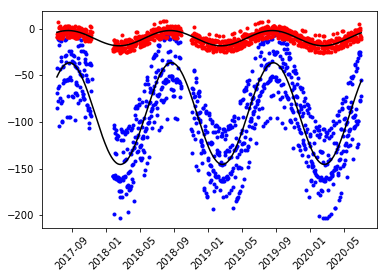

In [16]:
# Add back in n-day sine function here:
tsH_daily = y[:,0] + sine_wave(daily_P['FracYear'], params1[0],params1[1],params1[2])    
tsO_daily = y[:,1] + sine_wave(daily_P['FracYear'], params2[0],params2[1],params2[2])

daily_P['d2H'] = tsH_daily
daily_P['d18O'] = tsO_daily 

plt.figure()
plt.plot(daily_P.index, daily_P['d2H'],'b.')
plt.plot(daily_P.index, sine_wave(daily_P['FracYear'], params1[0],params1[1],params1[2]),'k')
plt.plot(daily_P.index, daily_P['d18O'],'r.')
plt.plot(daily_P.index, sine_wave(daily_P['FracYear'], params2[0],params2[1],params2[2]),'k') 
plt.xticks(rotation=45)

## 3. visualize output - i.e. time series plots and dual isotope plots

In [ ]:
# python or R scripts for plotting 1-2 sites (user can interchange site plotted by using unique site code (4 letter string))